In [2]:
import numpy as np 
import pandas as pd
from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sma
import sklearn.metrics as sm
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import math
from statsmodels.tsa.arima_model import ARMA
from itertools import product
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### Group Member
+ Zanyu Huang 2705275368
+ Weihao Wu 6422077403
+ Xintong Chen 7178305465

### Introduction

This article wants to focus on the problem of stock trading volume forecasting. Specifically, we hope to predict the trading volume using open_price, high_price, low_price, close_price of the stock itself.

The trading volume is the number of transactions of a unit in a certain period of time. The study of volume is of great significance. Trading volume, which represents investors' attention on stocks, also represents the popularity of individual stocks, which determines whether a stock has the potential to rise. The trading volume implies information on the activity of market transactions and the degree of disagreement on stock price, which is a precious reference for investment decisions. The trading volume directly reflects the relationship between supply and demand in the market. When the supply is in short, investors rush to buy, and the price naturally rises. Conversely, when the supply exceeds the demand, there are few buyers, the market sentiment is deserted, the trading volume shrinks, and the stock price is bound to fall.

In the process of reviewing the literature, we found that there are many achievements in the study of stock price prediction, and the discussion on trading volume is slightly less. We only introduce the literature that has the greatest effect on our article. The subject of this article is forecasting abnormal stock returns and trading volume using investor sentiment. Kissan Joseph, M. Babajide Wintoki, Zelin Zhang(https://www.sciencedirect.com/science/article/pii/S0169207011000021) examined the ability of online ticker searches (e.g. XOM for Exxon Mobil) to forecast abnormal stock returns and trading volumes and argued that online ticker searches serve as a valid proxy for investor sentiment — a set of beliefs about cash flows and investment risks that are not necessarily justified by the facts at hand — which is generally associated with less sophisticated, retail investors.  In a sample of S&P 500 firms over the period 2005–2008, they found that, over a weekly horizon, online search intensity reliably predicts abnormal stock returns and trading volumes, and that the sensitivity of returns to search intensity is positively related to the difficulty of a stock being arbitraged. More broadly, our study highlights the potential of employing online search data for other forecasting applications.

### Exploratory Data Analysis

We look for suitable stock time series data on kaggle, which should span a certain length of time and include its own different price information. Finally we found a dataset named '5 years historical stock quotes' from this link(https://www.kaggle.com/datasets/aleksthegreat/5years-dailystock-quotes/code).

We now take a look at this dataset and make some simple obsevations.

In [2]:
# read in data
data = pd.read_csv('original.csv')
data = data[['symbol','datetime','open_price','high_price','low_price','close_price','volume']]
data.columns = [['code','date','open','high','low','close','volume']]
# turn into date
data['date'] = np.array([x[:10] for x in data['date'].iloc[:,0]])
data['code'] = np.array(x for x in data['code'].iloc[:,0].values)
data

,code,date,open,high,low,close,volume
0,A,2016-02-16,36.72,37.17,36.4000,37.08,2903649
1,A,2016-02-17,35.22,38.13,34.7500,37.87,5382312
2,A,2016-02-18,37.73,37.96,37.0900,37.19,2231481
3,A,2016-02-19,36.90,37.60,36.8500,37.44,2339426
4,A,2016-02-22,37.82,38.19,37.7800,38.03,1792962
...,...,...,...,...,...,...,...
7801915,ZYXI,2021-02-08,19.28,20.47,19.2183,19.99,589014
7801916,ZYXI,2021-02-09,20.04,20.30,19.5000,19.99,300062
7801917,ZYXI,2021-02-10,20.45,20.53,19.0300,19.51,399141
7801918,ZYXI,2021-02-11,19.40,19.70,18.5201,19.28,322271


This time series data is from 2016.2.16-2021.2.12 and has 7801920 items, including data  on over 6000 publicly listed stocks from company A to ZYXI.

Because the data set in this article has a certain time span, the trading volume data may not have values at all times. Next, we look at the missing volume of these stocks, and then select the model objects with normal volume data.

In [3]:
# drop duplicates and find missing values
code_list, date_list = data['code'].drop_duplicates().iloc[:,0].values, data['date'].drop_duplicates().iloc[:,0].values
num_zero = pd.DataFrame(index = code_list,columns = ['count'])
for i in range(len(code_list)):
    temp = data[data['code'].iloc[:,0].values == code_list[i]]
    num_zero.loc[code_list[i]] = (temp['volume'] == 0).astype(int).sum(axis=0)[0]
num_zero

,count
A,1
AA,1
AACG,1
AACQ,1149
AACQU,1111
...,...
ZUO,544
ZVO,1
ZYME,304
ZYNE,1


In [4]:
# drop stocks with more than 1 zeros in volume
code_list = num_zero[num_zero.iloc[:,0].values==1].index.values
len(code_list)

3470

We find that all volumes of all stocks have zero values, which implify that every stock has at least an outlier. 3470 of these stocks have only one zero value during this period. This is likely to be caused by an abnormal data sampling on a certain day, and we will try to find this day.

In [5]:
# find the day with outliers
temp = data[data['volume'].iloc[:,0].values==0]
temp[[(code in code_list) for code in temp['code'].iloc[:,0].values]]['date'].drop_duplicates()

,date
708,2018-12-05


In [6]:
# drop the day with outliers
data = data.drop(data[data['date'].iloc[:,0].values == '2018-12-05'].index)

For those stocks with only one outlier, the date when the 0 value occurs is December 5, 2018. It is likely that there is a problem with the data sampling of this day, so remove the outlier of this day, and the data of these 3470 stocks is now normal. However, the amount of such data is still very large, so next we randomly select 12 stocks from the 3470 stocks after removing outliers for modeling.

In [7]:
# randomly select 12 stocks and form a new dataset
import random
#code_list = np.array(random.sample(list(code_list),12))
#code_list

array(['FFA', 'SPKE', 'RUSHA', 'VER', 'ATRI', 'VPG', 'NNI', 'AVGO',
       'SBAC', 'POWI', 'SAIA', 'BOOM'], dtype='<U5')

In [3]:
# the sample we used is ['FFA', 'SPKE', 'RUSHA', 'VER', 'ATRI', 'VPG', 'NNI', 'AVGO',
# 'SBAC', 'POWI', 'SAIA', 'BOOM']
# Because it seems that the random.seed does not work, so we fix the sample manually
# fix sample
code_list = np.array(['FFA','SPKE','RUSHA','VER','ATRI','VPG','NNI','AVGO','SBAC','POWI','SAIA','BOOM'])
code_list

array(['FFA', 'SPKE', 'RUSHA', 'VER', 'ATRI', 'VPG', 'NNI', 'AVGO',
       'SBAC', 'POWI', 'SAIA', 'BOOM'], dtype='<U5')

In [8]:
# extract volume data and explore trend of volume
from datetime import datetime, timedelta
temp_list = []
for i in range(len(code_list)):
    temp = data[data['code'].iloc[:,0].values==code_list[i]]
    temp = temp[['date','volume']]
    temp.index = temp['date'].iloc[:,0].values
    temp = temp['volume']
    temp.columns = [code_list[i]]
    temp_list.append(temp)
trend = pd.concat([temp for temp in temp_list],axis = 1)
trend

,FFA,SPKE,RUSHA,VER,ATRI,VPG,NNI,AVGO,SBAC,POWI,SAIA,BOOM
2016-02-16,50759,214350,626333,761476,8173,32726,170691,3852097,1108497,355294,384186,34496
2016-02-17,48466,100108,523661,932162,13474,28088,253152,3274208,1092891,328684,378780,76337
2016-02-18,45224,168542,430369,651694,2119,48581,138923,3920177,948782,187670,251452,49474
2016-02-19,45938,215324,379016,594402,3389,138862,128768,3111806,1247821,198140,195912,94304
2016-02-22,86172,348600,562316,623715,3266,109392,163351,2420365,1441074,219682,331510,31096
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,37637,238980,132667,844443,6451,36516,50109,1761131,824885,374314,301978,88693
2021-02-09,19833,361222,300375,945886,2994,43799,28668,1275922,477790,388771,196669,113064
2021-02-10,36594,141460,144936,1747137,2352,41946,53285,1459042,568066,284689,170027,167263
2021-02-11,20999,157113,341672,1100460,5084,59304,48594,1712354,571982,502799,205416,124597


The table above is the data of the 12 stocks we selected. Since time series modeling is basically based on the assumption of stationarity, so let's take a rough look at whether the historical data of these stocks are stationary. 

The respective ADF unit root test results for these twelve stocks are as follows. Because the magnitude and change of the volume data are relatively large, the logarithm is taken on volume to reduce its absolute value, which is convenient for calculation.

<Figure size 1296x1728 with 0 Axes>

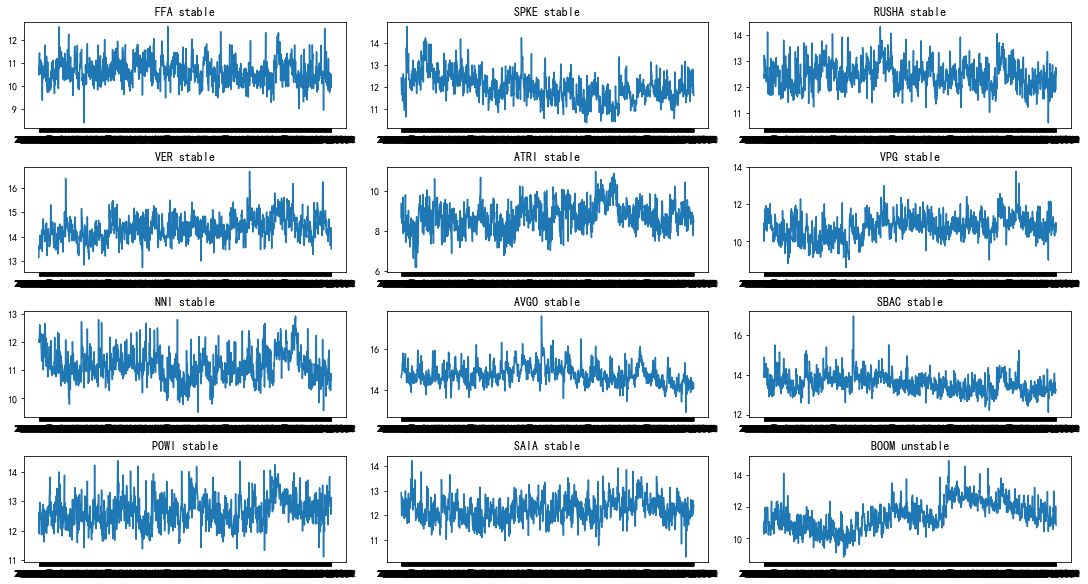

In [9]:
from statsmodels.tsa.stattools import adfuller
plt.figure(figsize=(18, 24)) 
fig,ax=plt.subplots(4,3, constrained_layout=True, figsize=(15, 8))   
for i in range(len(trend.columns)):
    test = np.log(trend.iloc[:,i].dropna().iloc[5:])
    p = adfuller(test)[1]
    ax[int(i//3)][int(i%3)].plot(test)
    # do ADF test
    if p<0.05:
        ax[int(i//3)][int(i%3)].set_title(test.name+' stable')
    else:
        ax[int(i//3)][int(i%3)].set_title(test.name+' unstable')
plt.show()

Stationarity cannot be seen intuitively from the figure, and further analysis is required with the help of other tools. The ADF unit root test was performed on them, and it is found that only one stock BOOM is not stationary. The data needs to be differentiated later. Above is a time-series image of the log volume of stocks picked out. There is obvious fluctuation clustering, and the follow-up may need to investigate the heteroscedasticity problem.

Let's examine the correlation of these 12 randomly selected stocks. See the figure below. It can be seen that the correlation is not strong, so if the modeling results for these twelve stocks are similar,it is appropriate to use the price of the stock itself to do volume forecasting.

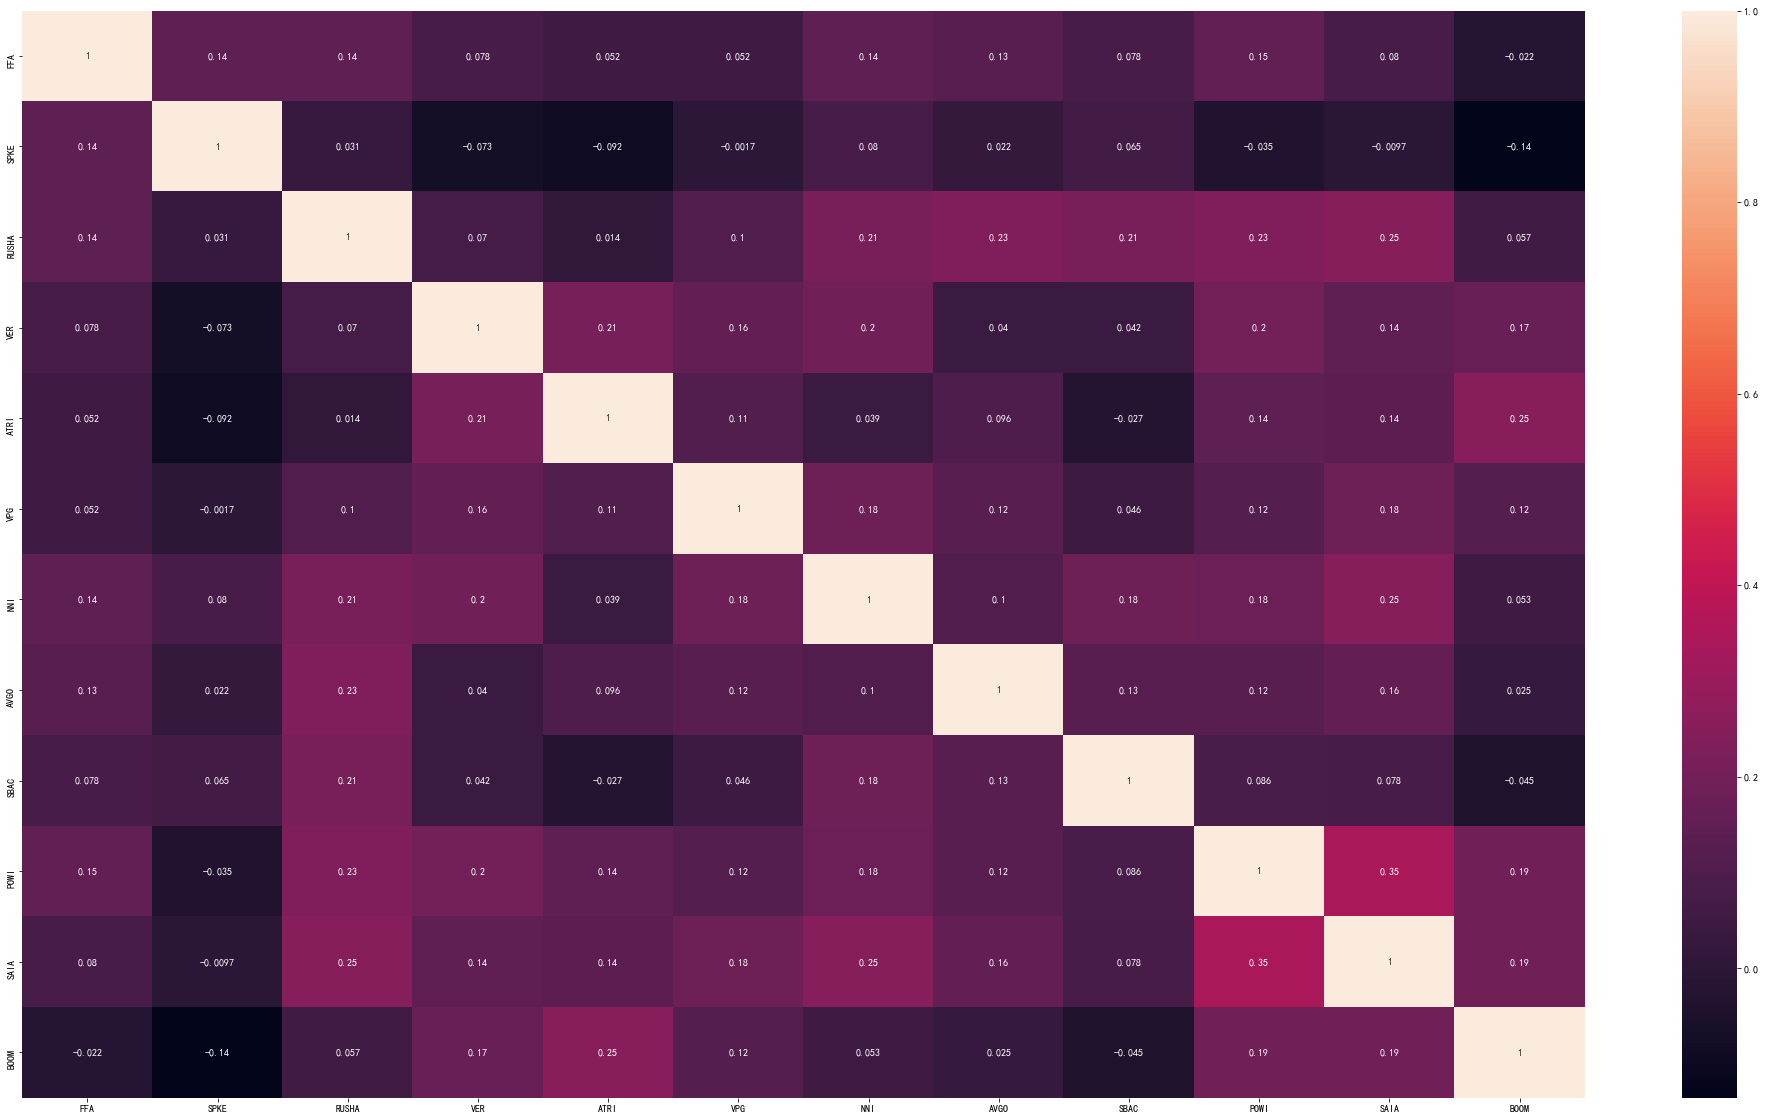

In [10]:
f, ax = plt.subplots(figsize=(35, 20))
sns.heatmap(trend.corr(), annot=True)
plt.savefig('correlation.png')

### Modeling

The purpose of this report is to establish ARIMA-GARCH models under different specifications for twelve stocks respectively to forecast volumes. This paper designs three specifications as follows:
+ ARIMA-GARCH model without covirates
+ ARIMAX-GARCH model with covirates(open price, close price, high price, low price)
+ ARIMAX-GARCH model with one covariate(close price)


Similar steps are performed under each srecification, as follows: 
+ Firstly, define a function to find the optimal order of the model under the restriction that the highest order of both AR and MA does not exceed 3;
+ Secondly, the unit root test is carried out on the logarithmic volume data of these twelve stocks. The series whose test result is stable can be directly modeled, and the series whose test result is not stable needs to be differentiated before fitting the model;
+ Thirdly, after simply fitting the ARIMA model, the residuals are tested for ARCH effects. If the test results show that there is an ARCH effect, a volatility GARCH model is fitted to the residuals;
+ Fourthly, use the optimal model to make five-step predictions on out-of sample data;
+ Finally, use the RMSE indicator (root mean square error) to evaluate the effect of the fifteen-step forecast.

In [11]:
step = 15 # do 15-step forecast 

#### Fit ARIMA model without covariates

In [12]:
from itertools import product
def get_best_arma(series):
    # set range of orders, don't want to fit high orders
    ps = range(0, 3)
    qs = range(0, 3)
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    # use aic criteria to choose model
    best_aic = float('inf')
    for param in parameters_list:
        try:
            model = ARMA(series, order=(param[0], param[1])).fit()
            aic = model.aic
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
        except:
            continue
    return best_model

In [13]:
# get log volume
data = np.log(trend)
data

,FFA,SPKE,RUSHA,VER,ATRI,VPG,NNI,AVGO,SBAC,POWI,SAIA,BOOM
2016-02-16,10.834844,12.275365,13.347637,13.543014,9.008591,10.395925,12.047610,15.164128,13.918516,12.780701,12.858882,10.448599
2016-02-17,10.788618,11.514005,13.168600,13.745262,9.508517,10.243098,12.441745,15.001587,13.904337,12.702852,12.844711,11.242913
2016-02-18,10.719383,12.034940,12.972398,13.387330,7.658700,10.790988,11.841675,15.181647,13.762934,12.142440,12.435007,10.809203
2016-02-19,10.735048,12.279899,12.845334,13.295311,8.128290,11.841236,11.765768,14.950714,14.036909,12.196729,12.185421,11.454279
2016-02-22,11.364101,12.761680,13.239819,13.343449,8.091321,11.602693,12.003657,14.699429,14.180899,12.299936,12.711413,10.344834
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,10.535743,12.384135,11.795598,13.646433,8.771990,10.505506,10.821956,14.381467,13.622999,12.832850,12.618109,11.392936
2021-02-09,9.895102,12.797248,12.612787,13.759877,8.004366,10.687366,10.263537,14.059180,13.076927,12.870746,12.189277,11.635709
2021-02-10,10.507640,11.859772,11.884048,14.373489,7.763021,10.644138,10.883410,14.193291,13.249993,12.559153,12.043713,12.027323
2021-02-11,9.952230,11.964721,12.741606,13.911239,8.533854,10.990432,10.791255,14.353380,13.256863,13.127946,12.232792,11.732840


Iteration:      1,   Func. Count:      8,   Neg. LLF: 174201.93067234807
Iteration:      2,   Func. Count:     25,   Neg. LLF: 2872.200609039006
Iteration:      3,   Func. Count:     35,   Neg. LLF: 14604.58517232024
Iteration:      4,   Func. Count:     46,   Neg. LLF: 4399.214464127225
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5437.542780480833
Iteration:      6,   Func. Count:     65,   Neg. LLF: 997.4887706893164
Iteration:      7,   Func. Count:     73,   Neg. LLF: 899.518642721373
Iteration:      8,   Func. Count:     82,   Neg. LLF: 774.9417374502322
Iteration:      9,   Func. Count:     90,   Neg. LLF: 750.9684956799505
Iteration:     10,   Func. Count:     97,   Neg. LLF: 758.9530083778604
Iteration:     11,   Func. Count:    105,   Neg. LLF: 788.3350689877924
Iteration:     12,   Func. Count:    113,   Neg. LLF: 823.9495394555925
Iteration:     13,   Func. Count:    121,   Neg. LLF: 982.595641242762
Iteration:     14,   Func. Count:    129,   Neg. LLF: 917.3237180

Iteration:      1,   Func. Count:      8,   Neg. LLF: 176197.59021417232
Iteration:      2,   Func. Count:     25,   Neg. LLF: 3040.047699055396
Iteration:      3,   Func. Count:     35,   Neg. LLF: 26899.778165279986
Iteration:      4,   Func. Count:     46,   Neg. LLF: 4007.2292676889956
Iteration:      5,   Func. Count:     55,   Neg. LLF: 5438.201025397532
Iteration:      6,   Func. Count:     65,   Neg. LLF: 821.3721330679541
Iteration:      7,   Func. Count:     73,   Neg. LLF: 915.7984720508596
Iteration:      8,   Func. Count:     81,   Neg. LLF: 775.2275688624354
Iteration:      9,   Func. Count:     89,   Neg. LLF: 754.7208030100915
Iteration:     10,   Func. Count:     97,   Neg. LLF: 753.959662456205
Iteration:     11,   Func. Count:    104,   Neg. LLF: 812.3198189815589
Iteration:     12,   Func. Count:    112,   Neg. LLF: 780.6407727251353
Iteration:     13,   Func. Count:    120,   Neg. LLF: 757.2580439014444
Iteration:     14,   Func. Count:    128,   Neg. LLF: 755.9213

Iteration:     51,   Func. Count:    412,   Neg. LLF: 751.352994121642
Optimization terminated successfully    (Exit mode 0)
            Current function value: 751.3529941216447
            Iterations: 51
            Function evaluations: 412
            Gradient evaluations: 51
Iteration:      1,   Func. Count:      8,   Neg. LLF: 176754.86227299765
Iteration:      2,   Func. Count:     25,   Neg. LLF: 78093.72644104346
Iteration:      3,   Func. Count:     35,   Neg. LLF: 36138.93430100854
Iteration:      4,   Func. Count:     45,   Neg. LLF: 6363.487001015354
Iteration:      5,   Func. Count:     54,   Neg. LLF: 1292.3402775674876
Iteration:      6,   Func. Count:     62,   Neg. LLF: 10446.749121790825
Iteration:      7,   Func. Count:     71,   Neg. LLF: 1453.0812452269836
Iteration:      8,   Func. Count:     79,   Neg. LLF: 4155.503890119646
Iteration:      9,   Func. Count:     88,   Neg. LLF: 1009.7663542397154
Iteration:     10,   Func. Count:     96,   Neg. LLF: 1419.0348185

Iteration:      1,   Func. Count:      8,   Neg. LLF: 176311.2595908565
Iteration:      2,   Func. Count:     25,   Neg. LLF: 74676.06427718847
Iteration:      3,   Func. Count:     35,   Neg. LLF: 36136.78441818859
Iteration:      4,   Func. Count:     45,   Neg. LLF: 6747.948650212247
Iteration:      5,   Func. Count:     54,   Neg. LLF: 1315.4493246910731
Iteration:      6,   Func. Count:     62,   Neg. LLF: 19630.308951998843
Iteration:      7,   Func. Count:     72,   Neg. LLF: 1465.8863326692817
Iteration:      8,   Func. Count:     80,   Neg. LLF: 1538.8738342380639
Iteration:      9,   Func. Count:     88,   Neg. LLF: 769.7045073949937
Iteration:     10,   Func. Count:     96,   Neg. LLF: 1706.849927650806
Iteration:     11,   Func. Count:    104,   Neg. LLF: 2363.3156504921326
Iteration:     12,   Func. Count:    114,   Neg. LLF: 784.5269992651153
Iteration:     13,   Func. Count:    122,   Neg. LLF: 754.4327153891469
Iteration:     14,   Func. Count:    129,   Neg. LLF: 754.1

Iteration:      1,   Func. Count:      8,   Neg. LLF: 179436.3092840645
Iteration:      2,   Func. Count:     25,   Neg. LLF: 78371.85726341294
Iteration:      3,   Func. Count:     35,   Neg. LLF: 36662.268853089015
Iteration:      4,   Func. Count:     45,   Neg. LLF: 5246.540909090059
Iteration:      5,   Func. Count:     54,   Neg. LLF: 1260.4226977286826
Iteration:      6,   Func. Count:     62,   Neg. LLF: 5156.357015635683
Iteration:      7,   Func. Count:     71,   Neg. LLF: 1340.0701993318762
Iteration:      8,   Func. Count:     79,   Neg. LLF: 1377.2442965691148
Iteration:      9,   Func. Count:     87,   Neg. LLF: 1404.2906114348802
Iteration:     10,   Func. Count:     95,   Neg. LLF: 45026.033681174784
Iteration:     11,   Func. Count:    112,   Neg. LLF: 6016.300019717164
Iteration:     12,   Func. Count:    124,   Neg. LLF: 268733.000585357
Iteration:     13,   Func. Count:    133,   Neg. LLF: 19992.073455393085
Iteration:     14,   Func. Count:    142,   Neg. LLF: 2664

Iteration:      1,   Func. Count:      8,   Neg. LLF: 9953.364391126117
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3803.048524082352
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1204.050836884235
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1100.7519369868928
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1096.4217483984196
Iteration:      6,   Func. Count:     57,   Neg. LLF: 1099.4122155215466
Iteration:      7,   Func. Count:     66,   Neg. LLF: 1087.0400227256769
Iteration:      8,   Func. Count:     73,   Neg. LLF: 1086.913527874413
Iteration:      9,   Func. Count:     80,   Neg. LLF: 1086.8412869277167
Iteration:     10,   Func. Count:     87,   Neg. LLF: 1086.8107239915926
Iteration:     11,   Func. Count:     94,   Neg. LLF: 1086.8075395852402
Iteration:     12,   Func. Count:    101,   Neg. LLF: 1086.8073804070123
Iteration:     13,   Func. Count:    108,   Neg. LLF: 1086.8073720340553
Iteration:     14,   Func. Count:    115,   Neg. LLF: 1

Iteration:      1,   Func. Count:      8,   Neg. LLF: 10054.333119990633
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3852.076887019907
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1200.4796775971995
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1098.5746611899267
Iteration:      5,   Func. Count:     48,   Neg. LLF: 1105.7530272437375
Iteration:      6,   Func. Count:     57,   Neg. LLF: 1106.0188596507912
Iteration:      7,   Func. Count:     66,   Neg. LLF: 1089.7961889614394
Iteration:      8,   Func. Count:     73,   Neg. LLF: 1089.6814244374812
Iteration:      9,   Func. Count:     80,   Neg. LLF: 1089.609156337401
Iteration:     10,   Func. Count:     87,   Neg. LLF: 1089.5843939429355
Iteration:     11,   Func. Count:     94,   Neg. LLF: 1089.581703370545
Iteration:     12,   Func. Count:    101,   Neg. LLF: 1089.5815432490117
Iteration:     13,   Func. Count:    108,   Neg. LLF: 1089.5815413879518
Iteration:     14,   Func. Count:    115,   Neg. LLF: 

Iteration:      1,   Func. Count:      8,   Neg. LLF: 9777.495368139404
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3927.146764026473
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1204.748152524433
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1103.380296590757
Iteration:      5,   Func. Count:     48,   Neg. LLF: 1114.8452886436196
Iteration:      6,   Func. Count:     57,   Neg. LLF: 1111.60266157516
Iteration:      7,   Func. Count:     66,   Neg. LLF: 1094.572612987541
Iteration:      8,   Func. Count:     73,   Neg. LLF: 1094.4673684300653
Iteration:      9,   Func. Count:     80,   Neg. LLF: 1094.350688966292
Iteration:     10,   Func. Count:     87,   Neg. LLF: 1094.3227875289404
Iteration:     11,   Func. Count:     94,   Neg. LLF: 1094.3180116780259
Iteration:     12,   Func. Count:    101,   Neg. LLF: 1094.3176585788235
Iteration:     13,   Func. Count:    108,   Neg. LLF: 1094.3176598138032
Optimization terminated successfully    (Exit mode 0)
     

Iteration:      1,   Func. Count:      8,   Neg. LLF: 135000.50500229403
Iteration:      2,   Func. Count:     25,   Neg. LLF: 56182.726538384304
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6930.869582707834
Iteration:      4,   Func. Count:     44,   Neg. LLF: 993.9818974015495
Iteration:      5,   Func. Count:     53,   Neg. LLF: 684.945522660076
Iteration:      6,   Func. Count:     60,   Neg. LLF: 683.4156665357375
Iteration:      7,   Func. Count:     67,   Neg. LLF: 682.9681044484566
Iteration:      8,   Func. Count:     74,   Neg. LLF: 682.8631082841621
Iteration:      9,   Func. Count:     81,   Neg. LLF: 682.6663810099328
Iteration:     10,   Func. Count:     88,   Neg. LLF: 682.6201453031559
Iteration:     11,   Func. Count:     95,   Neg. LLF: 682.6077321239962
Iteration:     12,   Func. Count:    102,   Neg. LLF: 682.6053074079105
Iteration:     13,   Func. Count:    109,   Neg. LLF: 682.6037683182308
Iteration:     14,   Func. Count:    116,   Neg. LLF: 682.60375

Iteration:      1,   Func. Count:      8,   Neg. LLF: 136419.8825429644
Iteration:      2,   Func. Count:     25,   Neg. LLF: 56771.90684328177
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6954.032946297733
Iteration:      4,   Func. Count:     44,   Neg. LLF: 995.1724941734229
Iteration:      5,   Func. Count:     53,   Neg. LLF: 690.5058310189328
Iteration:      6,   Func. Count:     60,   Neg. LLF: 690.3320175081675
Iteration:      7,   Func. Count:     68,   Neg. LLF: 689.597226266418
Iteration:      8,   Func. Count:     75,   Neg. LLF: 689.5404845738145
Iteration:      9,   Func. Count:     82,   Neg. LLF: 689.5335986147498
Iteration:     10,   Func. Count:     89,   Neg. LLF: 689.5301240083079
Iteration:     11,   Func. Count:     96,   Neg. LLF: 689.5300876875295
Iteration:     12,   Func. Count:    103,   Neg. LLF: 689.5300819726606
Iteration:     13,   Func. Count:    109,   Neg. LLF: 689.5300819726623
Optimization terminated successfully    (Exit mode 0)
           

Iteration:     38,   Func. Count:    350,   Neg. LLF: 686.3576364293825
Iteration:     39,   Func. Count:    358,   Neg. LLF: 609.5807006619664
Iteration:     40,   Func. Count:    366,   Neg. LLF: 587.6817739577665
Iteration:     41,   Func. Count:    374,   Neg. LLF: 569.8690408176769
Iteration:     42,   Func. Count:    381,   Neg. LLF: 566.1492568742756
Iteration:     43,   Func. Count:    388,   Neg. LLF: 565.0370208041331
Iteration:     44,   Func. Count:    395,   Neg. LLF: 564.4291545319427
Iteration:     45,   Func. Count:    402,   Neg. LLF: 564.2419591952621
Iteration:     46,   Func. Count:    409,   Neg. LLF: 563.930784317856
Iteration:     47,   Func. Count:    416,   Neg. LLF: 562.8717797058429
Iteration:     48,   Func. Count:    423,   Neg. LLF: 554.2323535837749
Iteration:     49,   Func. Count:    430,   Neg. LLF: 1755.8190945140668
Iteration:     50,   Func. Count:    438,   Neg. LLF: 1755.8107483612498
Iteration:     51,   Func. Count:    446,   Neg. LLF: 1754.6993

Iteration:      1,   Func. Count:      8,   Neg. LLF: 68739.15257312302
Iteration:      2,   Func. Count:     25,   Neg. LLF: 9709.720681445348
Iteration:      3,   Func. Count:     34,   Neg. LLF: 172294.63175708466
Iteration:      4,   Func. Count:     42,   Neg. LLF: 45605.80375584861
Iteration:      5,   Func. Count:     50,   Neg. LLF: 46665.459953575766
Iteration:      6,   Func. Count:     58,   Neg. LLF: 106583.2045997253
Iteration:      7,   Func. Count:     75,   Neg. LLF: 4900.164317472239
Iteration:      8,   Func. Count:     82,   Neg. LLF: 10009.484384451338
Iteration:      9,   Func. Count:     92,   Neg. LLF: 3146.9770338990643
Iteration:     10,   Func. Count:     99,   Neg. LLF: 4018.5637780067354
Iteration:     11,   Func. Count:    107,   Neg. LLF: 2582.3114335003456
Iteration:     12,   Func. Count:    115,   Neg. LLF: 6595.182604830832
Iteration:     13,   Func. Count:    123,   Neg. LLF: 3805.0636868850506
Iteration:     14,   Func. Count:    133,   Neg. LLF: 820

Iteration:      1,   Func. Count:      8,   Neg. LLF: 69187.1262770817
Iteration:      2,   Func. Count:     25,   Neg. LLF: 9570.97657667186
Iteration:      3,   Func. Count:     34,   Neg. LLF: 164754.2037897145
Iteration:      4,   Func. Count:     42,   Neg. LLF: 38215.93871301273
Iteration:      5,   Func. Count:     50,   Neg. LLF: 39576.808400358685
Iteration:      6,   Func. Count:     58,   Neg. LLF: 186714.1743532774
Iteration:      7,   Func. Count:     66,   Neg. LLF: 4255.002883888203
Iteration:      8,   Func. Count:     76,   Neg. LLF: 95656.74307005382
Iteration:      9,   Func. Count:     84,   Neg. LLF: 16741.159362753206
Iteration:     10,   Func. Count:     92,   Neg. LLF: 105105.79259728492
Iteration:     11,   Func. Count:    100,   Neg. LLF: 98099.7221921632
Iteration:     12,   Func. Count:    108,   Neg. LLF: 98375.98754709012
Iteration:     13,   Func. Count:    116,   Neg. LLF: 37600.68680355652
Iteration:     14,   Func. Count:    124,   Neg. LLF: 86489.4188

Iteration:      1,   Func. Count:      8,   Neg. LLF: 69443.09846222344
Iteration:      2,   Func. Count:     25,   Neg. LLF: 9622.635625941733
Iteration:      3,   Func. Count:     34,   Neg. LLF: 167632.39836397255
Iteration:      4,   Func. Count:     42,   Neg. LLF: 39952.92680403813
Iteration:      5,   Func. Count:     50,   Neg. LLF: 7214.254594785757
Iteration:      6,   Func. Count:     58,   Neg. LLF: 128166.77969271291
Iteration:      7,   Func. Count:     75,   Neg. LLF: 7180.806312431012
Iteration:      8,   Func. Count:     82,   Neg. LLF: 6039.4516500711925
Iteration:      9,   Func. Count:     89,   Neg. LLF: 9365.199672878203
Iteration:     10,   Func. Count:     98,   Neg. LLF: 5805.462743517656
Iteration:     11,   Func. Count:    107,   Neg. LLF: 2568.0348664634203
Iteration:     12,   Func. Count:    115,   Neg. LLF: 13743.107761675354
Iteration:     13,   Func. Count:    123,   Neg. LLF: 13923.207529855266
Iteration:     14,   Func. Count:    131,   Neg. LLF: 915.

Iteration:     53,   Func. Count:    445,   Neg. LLF: 580.0417525648319
Iteration:     54,   Func. Count:    453,   Neg. LLF: 2034.2508520646368
Iteration:     55,   Func. Count:    461,   Neg. LLF: 568.9322689060962
Iteration:     56,   Func. Count:    469,   Neg. LLF: 545.6186555678421
Iteration:     57,   Func. Count:    476,   Neg. LLF: 545.4136644556712
Iteration:     58,   Func. Count:    484,   Neg. LLF: 544.0595427546384
Iteration:     59,   Func. Count:    491,   Neg. LLF: 543.0516707985594
Iteration:     60,   Func. Count:    498,   Neg. LLF: 542.468861810149
Iteration:     61,   Func. Count:    505,   Neg. LLF: 542.3876061349308
Iteration:     62,   Func. Count:    512,   Neg. LLF: 542.3645857520452
Iteration:     63,   Func. Count:    519,   Neg. LLF: 542.3504436610178
Iteration:     64,   Func. Count:    526,   Neg. LLF: 542.3455526533166
Iteration:     65,   Func. Count:    533,   Neg. LLF: 542.3452336326751
Iteration:     66,   Func. Count:    540,   Neg. LLF: 542.345216

Iteration:     50,   Func. Count:    440,   Neg. LLF: 2072.2766945881604
Iteration:     51,   Func. Count:    448,   Neg. LLF: 747.2843095898294
Iteration:     52,   Func. Count:    456,   Neg. LLF: 633.6902658624701
Iteration:     53,   Func. Count:    463,   Neg. LLF: 614.3512864218138
Iteration:     54,   Func. Count:    470,   Neg. LLF: 608.6269851566883
Iteration:     55,   Func. Count:    477,   Neg. LLF: 634.5235239419087
Iteration:     56,   Func. Count:    485,   Neg. LLF: 621.3772192015874
Iteration:     57,   Func. Count:    493,   Neg. LLF: 604.995530337927
Iteration:     58,   Func. Count:    500,   Neg. LLF: 603.314670357804
Iteration:     59,   Func. Count:    507,   Neg. LLF: 600.2388559822336
Iteration:     60,   Func. Count:    514,   Neg. LLF: 592.6810792654969
Iteration:     61,   Func. Count:    521,   Neg. LLF: 592.8703425032908
Iteration:     62,   Func. Count:    529,   Neg. LLF: 581.723578858795
Iteration:     63,   Func. Count:    536,   Neg. LLF: 581.47499631

/opt/anaconda3/envs/notebook-6.0.3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.




Iteration:      1,   Func. Count:      8,   Neg. LLF: 69806.5180210892
Iteration:      2,   Func. Count:     25,   Neg. LLF: 9732.07533545393
Iteration:      3,   Func. Count:     34,   Neg. LLF: 172949.9940976313
Iteration:      4,   Func. Count:     42,   Neg. LLF: 43365.36062099124
Iteration:      5,   Func. Count:     50,   Neg. LLF: 44814.1592252231
Iteration:      6,   Func. Count:     58,   Neg. LLF: 78301.0077079873
Iteration:      7,   Func. Count:     66,   Neg. LLF: 125975.12213031853
Iteration:      8,   Func. Count:     83,   Neg. LLF: 6999.010358664575
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4209.390147213122
Iteration:     10,   Func. Count:     97,   Neg. LLF: 6855.20276360629
Iteration:     11,   Func. Count:    106,   Neg. LLF: 3512.68511745304
Iteration:     12,   Func. Count:    114,   Neg. LLF: 12213.48762788557
Iteration:     13,   Func. Count:    122,   Neg. LLF: 8448.801652922788
Iteration:     14,   Func. Count:    130,   Neg. LLF: 2316.8635381911

<Figure size 1296x1296 with 0 Axes>

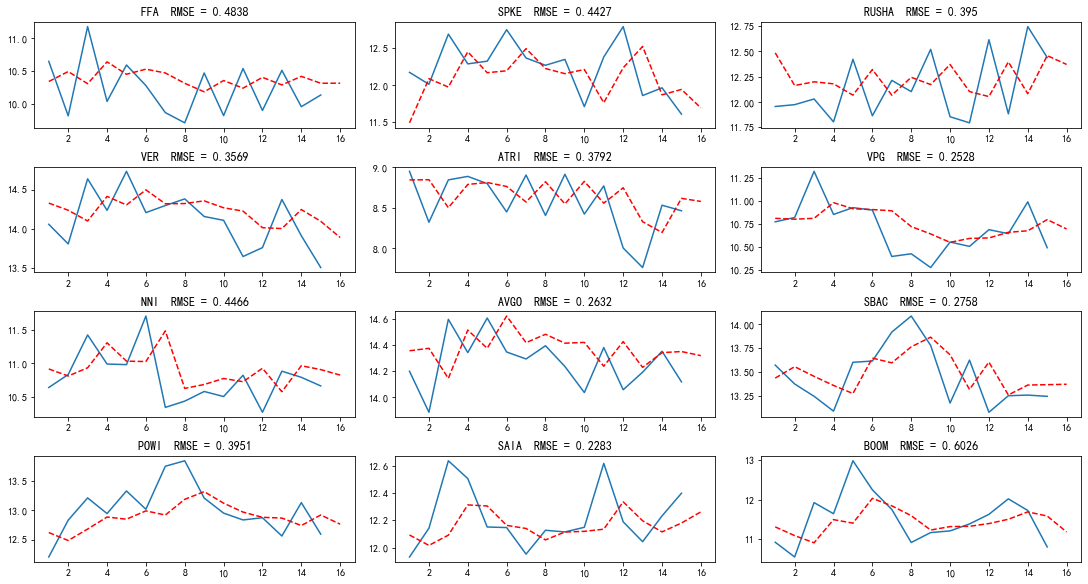

In [14]:
from arch import arch_model
plt.figure(figsize=(18, 18)) 
fig,ax=plt.subplots(4,3, constrained_layout=True, figsize=(15, 8))  
RMSE_1_list = []
pred_1_list = []
for i in range(len(data.columns)):
    name = data.columns[i]
    test = data.iloc[:,i].dropna()
    fc_list = []
    adf = adfuller(test.iloc[5:])[1]
    
    # there exists a unit root
    if adf >0.05:
        test = test.diff().iloc[5:]
        print(name + 'Fail ADF Test,p = \n',adf)
        # fit the model using rolling window   
        for j in range(step):
            temp = test.iloc[:-(step-j)]            
            best_model = get_best_arma(temp)
            # decide if we need to fit volatility model
            resid = best_model.resid
            LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
            if LjungBox[1][-1]<0.05:# need to fit volatility model
                best_model = arch_model(temp, mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
                fc = best_model.forecast(horizon=1)
                fc_list.append(fc.mean.iloc[-1].values[0]+data.iloc[-(step-j)-1,i])
            else:
                fc_list.append(best_model.forecast(1)[0][0]+data.iloc[-(step-j)-1,i])
        temp = test.iloc[:]
        # get best model
        best_model = get_best_arma(temp)
        resid = best_model.resid
        LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
        if LjungBox[1][-1]<0.05:
            best_model = arch_model(temp, mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
            fc = best_model.forecast(horizon=1)
            fc_list.append(fc.mean.iloc[-1].values[0]+data.iloc[-1,i])
        else:
            fc_list.append(best_model.forecast(1)[0][0]+data.iloc[-1,i]) 

        # print out stocks that need a volatility model
        if LjungBox[1][-1]<0.05:
            print(name+' need volatility model，p-value of ARCH effect = ', LjungBox[1][-1]) 
        
    # there is no unit root  
    else:
        test = test.iloc[5:]
         # rolling window fit    
        for j in range(step):
            temp = test.iloc[:-(step-j)]
            best_model = get_best_arma(temp)
            resid = best_model.resid
            LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
            if LjungBox[1][-1]<0.05:
                best_model = arch_model(temp, mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
                fc = best_model.forecast(horizon=1)
                fc_list.append(fc.mean.iloc[-1].values[0])
            else:
                fc_list.append(best_model.forecast(1)[0][0])
        temp = test
        best_model = get_best_arma(temp)
        resid = best_model.resid
        LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
        if LjungBox[1][-1]<0.05:
            best_model = arch_model(temp, mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
            fc = best_model.forecast(horizon=1)
            fc_list.append(fc.mean.iloc[-1].values[0])
        else:
            fc_list.append(best_model.forecast(1)[0][0])

        if LjungBox[1][-1]<0.05:
            print(name+' need volatility model，p-value of ARCH effect = ', LjungBox[1][-1]) 
            

    outsample = data.iloc[:,i].dropna().iloc[-step:]
    fc = pd.DataFrame(fc_list, index = [k+1 for k in range(step+1)])
    outsample.index = [k+1 for k in range(step)]
    RMSE = np.sqrt(sm.mean_squared_error(outsample,fc.iloc[:-1]))
    RMSE_1_list.append(RMSE)
    ax[i//3][i%3].plot(outsample,label='true')
    ax[i//3][i%3].plot(fc,color='r', ls='--', label='forecast')
    ax[i//3][i%3].set_title(name+'  RMSE = '+str(round(RMSE,4)))    
    pred_1_list.append(fc_list[-1])

plt.show()

It can be seen that the simple ARIMA-GARCH model captures the trends of SPKE, RUSHA, NNI, AVGO and SBAC well, and predicts the direction and magnitude of the ups and downs more accurately. The remaining stocks, although capturing the trend change, have a certain gap in value, more like a smoothed version.

#### Fit ARIMA model with covariates: open_price, close_price, high_price, low_price

In [15]:
# read in data
data = pd.read_csv('original.csv')
data = data[['symbol','datetime','open_price','high_price','low_price','close_price','volume']]
data.columns = [['code','date','open','high','low','close','volume']]
# turn into optimal form
data['date'] = np.array([x[:10] for x in data['date'].iloc[:,0]])
data['code'] = np.array(x for x in data['code'].iloc[:,0].values)
data = data.drop(data[data['date'].iloc[:,0].values == '2018-12-05'].index)

In [16]:
select = [code in code_list for code in data['code'].iloc[:,0].values]
data = data[select]
data['volume'] = np.log(data['volume'])
data

,code,date,open,high,low,close,volume
642600,ATRI,2016-02-16,396.000,403.708,394.230,400.59,9.008591
642601,ATRI,2016-02-17,415.000,415.000,384.500,408.00,9.508517
642602,ATRI,2016-02-18,401.320,403.025,396.000,396.00,7.658700
642603,ATRI,2016-02-19,384.900,397.090,380.200,388.70,8.128290
642604,ATRI,2016-02-22,372.492,391.110,372.492,389.00,8.091321
...,...,...,...,...,...,...,...
7420135,VPG,2021-02-08,34.050,35.000,34.010,34.99,10.505506
7420136,VPG,2021-02-09,34.870,35.080,34.350,35.01,10.687366
7420137,VPG,2021-02-10,35.170,35.170,34.200,34.45,10.644138
7420138,VPG,2021-02-11,35.140,35.140,33.840,34.28,10.990432


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def get_best_sarimax(series):
    y_train = np.array(series['volume'])
    x_train = np.array(series[['open','close','high','low']])
    ps = range(0,3)
    qs = range(0,3)
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    best_aic = float('inf')
    best_model = SARIMAX(y_train, exog=x_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0)).fit()
    for param in parameters_list:
        try:
            model = SARIMAX(y_train, exog=x_train, order=(param[0], 0, param[1]), seasonal_order=(0, 0, 0, 0)).fit()
            aic = model.aic
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
        except:
            continue
    return best_model

BOOM Fail ADF Test,p = 
 3.23951975236134e-25


<Figure size 1296x1296 with 0 Axes>

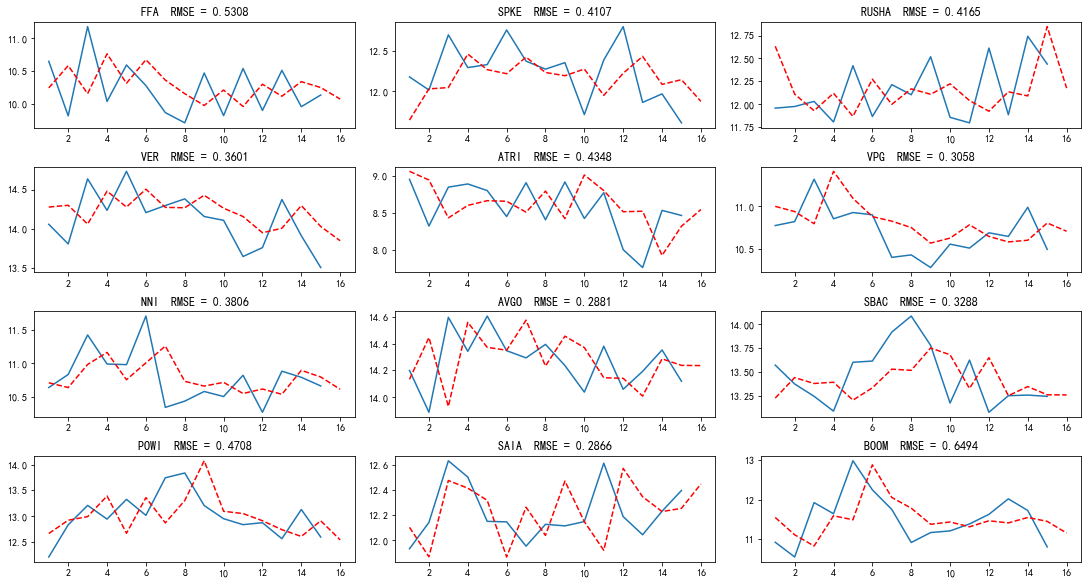

In [18]:
plt.figure(figsize=(18, 18)) 
fig,ax=plt.subplots(4,3, constrained_layout=True, figsize=(15, 8))   
RMSE_2_list = []
pred_2_list = []
for i in range(len(code_list)):
    test = data[data['code'].iloc[:,0].values==code_list[i]].iloc[5:]
    fc_list = []
    
    # there exists unit root
    if adfuller(test['volume'])[1] >0.05:
        test = data[data['code'].iloc[:,0].values==code_list[i]]
        test['volume'] = test['volume'].diff()
        test = test.iloc[5:,:]
        print(code_list[i] + ' Fail ADF Test,p = \n',adfuller(test['volume'])[1])
        # rolling window fit
        for j in range(step):
            temp = test.iloc[:-(step-j),:]
            best_model = get_best_sarimax(temp)
            # whether we need volatility model
            resid = best_model.resid
            LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
            if LjungBox[1][-1]<0.05:
                best_model = arch_model(y=temp['volume'],x=np.array(temp[['open','close','high','low']]), 
                                   mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
                fc = best_model.forecast(horizon=1)
                fc_list.append(fc.mean.iloc[-1].values[0] + data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-(step-j)-1])
            else:
                fc_list.append(best_model.forecast(1,exog = np.array(test[['open','close','high','low']].iloc[-(step-j)-1,:]))[0]
                              +data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-(step-j)-1]) 

        temp = test.iloc[:,:]
        best_model = get_best_sarimax(temp)
        resid = best_model.resid
        LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
        if LjungBox[1][-1]<0.05:
            best_model = arch_model(y=temp['volume'],x=np.array(temp[['open','close','high','low']]), 
                               mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
            fc = best_model.forecast(horizon=1)
            fc_list.append(fc.mean.iloc[-1].values[0] + data[data['code']==code_list[i]]['volume'].iloc[-1])
        else:
            fc_list.append(best_model.forecast(1,exog = np.array(test[['open','close','high','low']].iloc[-1,:]))[0]
                          +data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-1]) 
        
        if LjungBox[1][-1]<0.05:# there exists ARCH effect, need to fit volatility model
            print(code_list[i]+' need volatility model，p-value of ARCH effect = ', LjungBox[1][-1])  
        
    # there is no unit root 
    else:
        for j in range(step):
            temp = test.iloc[:-(step-j),:]
            best_model = get_best_sarimax(temp)
            resid = best_model.resid
            LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
            if LjungBox[1][-1]<0.05:
                best_model = arch_model(y=temp['volume'],x=np.array(temp[['open','close','high','low']]), 
                                   mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
                fc = best_model.forecast(horizon=1)
                fc_list.append(fc.mean.iloc[-1].values[0])
            else:
                fc_list.append(best_model.forecast(1,exog = np.array(test[['open','close','high','low']].iloc[-(step-j)-1,:]))[0]) 
        temp = test.iloc[:,:]
        best_model = get_best_sarimax(temp)
        resid = best_model.resid
        LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
        if LjungBox[1][-1]<0.05:
            best_model = arch_model(y=temp['volume'],x=np.array(temp[['open','close','high','low']]), 
                               mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
            fc = best_model.forecast(horizon=1)
            fc_list.append(fc.mean.iloc[-1].values[0])
        else:
            fc_list.append(best_model.forecast(1,exog = np.array(test[['open','close','high','low']].iloc[-1,:]))[0]) 
    
        if LjungBox[1][-1]<0.05:
            print(code_list[i]+' need volatility model，p-value of ARCH effect = ', LjungBox[1][-1])  
            

    outsample = data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-step:]
    fc = pd.DataFrame(fc_list, index = [k+1 for k in range(step+1)])
    outsample.index = [k+1 for k in range(step)]
    RMSE = np.sqrt(sm.mean_squared_error(outsample,fc.iloc[:-1]))
    RMSE_2_list.append(RMSE)
    ax[i//3][i%3].plot(outsample,label='real')
    ax[i//3][i%3].plot(fc,color='r', ls='--', label='forecast')
    ax[i//3][i%3].set_title(test['code'].iloc[0].values[0]+'  RMSE = '+str(round(RMSE,4)))    
    pred_2_list.append(fc_list[-1]) 
    
plt.show()

Compared with the previous model, the model with open price, close price, high price and low price coviarates can more accurately capture the trends and changes of FFA and BOOM stocks, and the prediction effect has been improved to a certain extent.

#### Fit ARIMA model with covariates: close_price

In [19]:
# read in data
data = pd.read_csv('original.csv')
data = data[['symbol','datetime','open_price','high_price','low_price','close_price','volume']]
data.columns = [['code','date','open','high','low','close','volume']]
# turn into optimal form
data['date'] = np.array([x[:10] for x in data['date'].iloc[:,0]])
data['code'] = np.array(x for x in data['code'].iloc[:,0].values)
data = data.drop(data[data['date'].iloc[:,0].values == '2018-12-05'].index)

In [20]:
select = [code in code_list for code in data['code'].iloc[:,0].values]
data = data[select]
data['volume'] = np.log(data['volume'])
data

,code,date,open,high,low,close,volume
642600,ATRI,2016-02-16,396.000,403.708,394.230,400.59,9.008591
642601,ATRI,2016-02-17,415.000,415.000,384.500,408.00,9.508517
642602,ATRI,2016-02-18,401.320,403.025,396.000,396.00,7.658700
642603,ATRI,2016-02-19,384.900,397.090,380.200,388.70,8.128290
642604,ATRI,2016-02-22,372.492,391.110,372.492,389.00,8.091321
...,...,...,...,...,...,...,...
7420135,VPG,2021-02-08,34.050,35.000,34.010,34.99,10.505506
7420136,VPG,2021-02-09,34.870,35.080,34.350,35.01,10.687366
7420137,VPG,2021-02-10,35.170,35.170,34.200,34.45,10.644138
7420138,VPG,2021-02-11,35.140,35.140,33.840,34.28,10.990432


In [21]:
from itertools import product
def get_best_sarimax(series):
    y_train = np.array(series['volume'])
    x_train = np.array(series[['close']])
    ps = range(0,3)
    qs = range(0,3)
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    best_aic = float('inf')
    for param in parameters_list:
        try:
            model = SARIMAX(y_train, exog=x_train, order=(param[0], 0, param[1]), seasonal_order=(0, 0, 0, 0)).fit()
            aic = model.aic
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
        except:
            continue
    return best_model

BOOMFail ADF Test,p = 
 3.23951975236134e-25


<Figure size 1296x1296 with 0 Axes>

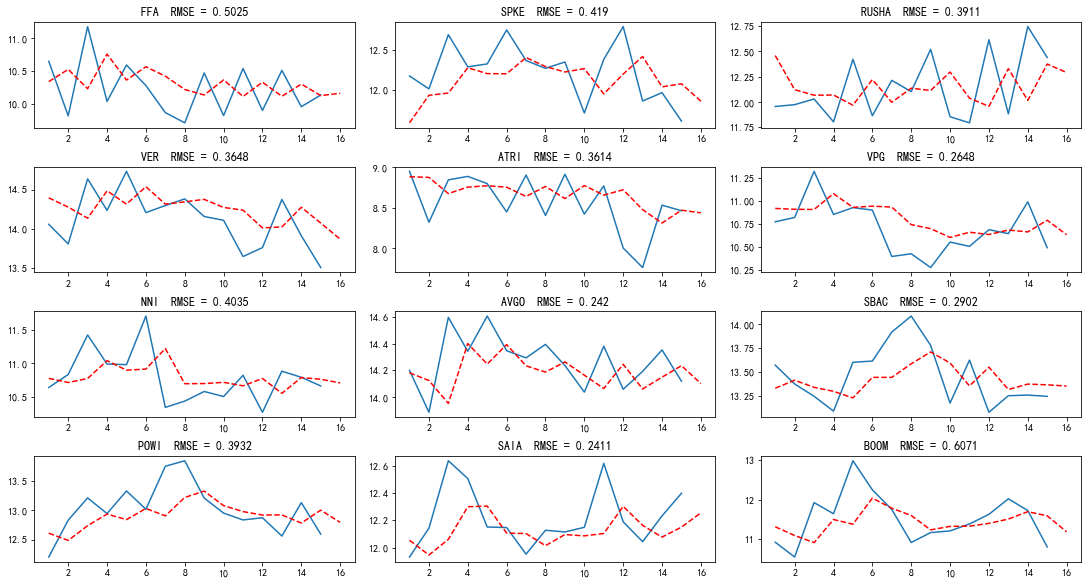

In [22]:
plt.figure(figsize=(18, 18)) 
fig,ax=plt.subplots(4,3, constrained_layout=True, figsize=(15, 8))   
RMSE_3_list = []
pred_3_list = []
for i in range(len(code_list)):
    test = data[data['code'].iloc[:,0].values==code_list[i]].iloc[5:]
    fc_list = []
    
    # there exists unit root
    if adfuller(test['volume'])[1] >0.05:
        test = data[data['code'].iloc[:,0].values==code_list[i]]
        test['volume'] = test['volume'].diff()
        test = test.iloc[5:,:]
        print(code_list[i] + 'Fail ADF Test,p = \n',adfuller(test['volume'])[1])
        # rolling window fit
        for j in range(step):
            temp = test.iloc[:-(step-j),:]
            best_model = get_best_sarimax(temp)
            # whether we need volatility model
            resid = best_model.resid
            LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
            if LjungBox[1][-1]<0.05:
                best_model = arch_model(y=temp['volume'],x=np.array(temp[['close']]), 
                                   mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
                fc = best_model.forecast(horizon=1)
                fc_list.append(fc.mean.iloc[-1].values[0] + data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-(step-j)-1])
            else:
                fc_list.append(best_model.forecast(1,exog = np.array(test[['close']].iloc[-(step-j)-1,:]))[0]
                              +data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-(step-j)-1]) 

        temp = test.iloc[:,:]
        best_model = get_best_sarimax(temp)
        resid = best_model.resid
        LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
        if LjungBox[1][-1]<0.05:
            best_model = arch_model(y=temp['volume'],x=np.array(temp[['close']]), 
                               mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
            fc = best_model.forecast(horizon=1)
            fc_list.append(fc.mean.iloc[-1].values[0] + data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-1])
        else:
            fc_list.append(best_model.forecast(1,exog = np.array(test[['close']].iloc[-1,:]))[0]
                          +data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-1]) 
        
        if LjungBox[1][-1]<0.05:
            print(code_list[i]+' need volatility model，p-value of ARCH effect = ', LjungBox[1][-1])  
        
    # there is no unit root 
    else:
        for j in range(step):
            temp = test.iloc[:-(step-j),:]
            best_model = get_best_sarimax(temp)
            resid = best_model.resid
            LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
            if LjungBox[1][-1]<0.05:
                best_model = arch_model(y=temp['volume'],x=np.array(temp[['close']]), 
                                   mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
                fc = best_model.forecast(horizon=1)
                fc_list.append(fc.mean.iloc[-1].values[0])
            else:
                fc_list.append(best_model.forecast(1,exog = np.array(test[['close']].iloc[-(step-j)-1,:]))[0]) 
        temp = test.iloc[:,:]
        best_model = get_best_sarimax(temp)
        resid = best_model.resid
        LjungBox=stattools.q_stat(stattools.acf(resid**2)[1:13],len(resid))
        if LjungBox[1][-1]<0.05:
            best_model = arch_model(y=temp['volume'],x=np.array(temp[['close']]), 
                               mean='AR', lags=1, vol='Garch', p=1, o=0, q=1, power=2.0, dist='t').fit()
            fc = best_model.forecast(horizon=1)
            fc_list.append(fc.mean.iloc[-1].values[0])
        else:
            fc_list.append(best_model.forecast(1,exog = np.array(test[['close']].iloc[-1,:]))[0]) 
    
        if LjungBox[1][-1]<0.05:
            print(code_list[i]+' need volatility model，p-value of ARCH effect = ', LjungBox[1][-1])  
            

    outsample = data[data['code'].iloc[:,0].values==code_list[i]]['volume'].iloc[-step:]
    fc = pd.DataFrame(fc_list, index = [k+1 for k in range(step+1)])
    outsample.index = [k+1 for k in range(step)]
    RMSE = np.sqrt(sm.mean_squared_error(outsample,fc.iloc[:-1]))
    RMSE_3_list.append(RMSE)
    ax[i//3][i%3].plot(outsample,label='real')
    ax[i//3][i%3].plot(fc,color='r', ls='--', label='forecast')
    ax[i//3][i%3].set_title(test['code'].iloc[:,0].values[0]+'  RMSE = '+str(round(RMSE,4)))    
    pred_3_list.append(fc_list[-1]) 
    
plt.show()

Compared with the previous model, the model with only close proce coviarate is less able to predict several stocks such as VPG, NNI, AVGO, SAIA and BOOM.

#### Prediction Comparison

In [23]:
# outsample RMSE comparision
res_RMSE = pd.concat([pd.DataFrame(RMSE_1_list),pd.DataFrame(RMSE_2_list),
                 pd.DataFrame(RMSE_3_list)],axis = 1)
res_RMSE.index = code_list
res_RMSE.columns = ['model1','model2','model3']
res_RMSE.index.name = 'RMSE comparision'
res_RMSE

,model1,model2,model3
RMSE comparision,,,
FFA,0.483761,0.530807,0.502524
SPKE,0.442727,0.410717,0.419027
RUSHA,0.395032,0.416491,0.391108
VER,0.356947,0.360083,0.364794
ATRI,0.379176,0.434764,0.361421
VPG,0.252777,0.305835,0.264778
NNI,0.446603,0.380581,0.403460
AVGO,0.263152,0.288095,0.241951
SBAC,0.275819,0.328772,0.290244


For most stocks, the ARIMA-GARCH model without coviarates has the smallest error, and the simplest model is the most practical when there is no significant difference in forecasting performance.

It can be seen that the three models have little change in the prediction error ranking of these stocks, and there is no significant change in the prediction error ranking of a certain stock under the three models, so the model is relatively robust.

### Conclusion

In this report, we first looked at the missing data, and then found that there is an abnormal date (December 5, 2018), after deleting the data in the abnormal date, there are 3470 stocks without missing values left. Next, we randomly selected 12 of these stocks to build three ARIMA-GARCH models, visualized their 15-step forecast results, and compared the effects of the three models. In addition, the respective RMSEs were also counted to examine the stability of the model.

Through the comparison of the three models, it can be seen that the effect of introducing price as coviarates is not as good as the autoregressive model of volume, which shows that price is not an indicator that can reveal the changing law of volume. 

In the future, we should find more information about other factors that have an impact on changes in trading volume and use them for further analysis.